In [80]:
# Import packages
import os
os.environ['WANDB_DISABLED'] = 'true'
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# import wandb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, load_metric
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,accuracy_score

In [2]:
!nvidia-smi

Tue May  3 17:14:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   36C    P0    24W / 250W |      0MiB / 16160MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:D8:00.0 Off |                    0 |
| N/A   

In [3]:
# Specify GPU
device = torch.device("cuda:0")

In [4]:
!pip install -qqq transformers datasets wandb

In [4]:
# Define constants
EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
SEED = 4222

MODEL_SAVE_PATH = "Model_2/electra"
MODEL_CHECKPOINT_PATH = "Model_2/electra_checkpoint"
MODEL_LOGGING_PATH = "Model_2/electra_checkpoint/logs"

# WANDB_ENTITY = "gohjiayi"
# WANDB_PROJECT = "suicide_detection"
# WANDB_RUN = "electra"

In [5]:
df = pd.read_csv('full_training_data.csv')

In [6]:
test = pd.read_csv('full_test_data.csv')

In [7]:
test.head()

,Unnamed: 0,Polarity,text
0,0,1,musical awareness: great big beautiful tomorro...
1,1,0,"kapan sih lo ngebuktiin,jan ngomong doang susa..."
2,2,1,show your love for your local field & it might...
3,3,1,can you tell me when an update for the apple ...
4,4,1,"the crown, filthy mcnastys, katy dalys or the..."


In [8]:
# Split dataset into train, validation and test sets
train, val = train_test_split(df,
                               random_state=SEED,
                               test_size=0.2,
                               stratify=df['Polarity'])

In [9]:
# Load ELECTRA tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/electra-small-discriminator", do_lower_case = True)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [10]:
# Import ELECTRA-base pretrained model
model = AutoModelForSequenceClassification.from_pretrained("google/electra-small-discriminator", num_labels=2)

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

In [11]:
def dataset_conversion(train, test, val):
  """Converts pandas dataframe to Dataset."""

  train.reset_index(drop=True, inplace=True)
  test.reset_index(drop=True, inplace=True)
  val.reset_index(drop=True, inplace=True)

  train_dataset = Dataset.from_pandas(train)
  test_dataset = Dataset.from_pandas(test)
  val_dataset = Dataset.from_pandas(val)

  return DatasetDict({"train": train_dataset,
                      "test": test_dataset,
                      "val": val_dataset})

raw_datasets = dataset_conversion(train, test, val)

In [12]:
def tokenize_function(dataset):
    return tokenizer(dataset["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

  0%|          | 0/1280 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/320 [00:00<?, ?ba/s]

In [13]:
# Tokenise datasets
SAMPLE_SIZE = 20
small_train_dataset = tokenized_datasets["train"].shuffle(seed=SEED).select(range(SAMPLE_SIZE))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=SEED).select(range(SAMPLE_SIZE))
small_val_dataset = tokenized_datasets["val"].shuffle(seed=SEED).select(range(SAMPLE_SIZE))

full_train_dataset = tokenized_datasets["train"]
full_test_dataset = tokenized_datasets["test"]
full_val_dataset = tokenized_datasets["val"]

In [14]:
full_train_dataset = full_train_dataset.rename_column("Polarity", "label")
full_test_dataset = full_test_dataset.rename_column("Polarity", "label")
full_val_dataset = full_val_dataset.rename_column("Polarity", "label")

In [15]:
# Define custom metrics for computation
def compute_metrics(eval_pred):
    metric_acc = load_metric("accuracy")
    metric_rec = load_metric("recall")
    metric_pre = load_metric("precision")
    metric_f1 = load_metric("f1")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = metric_acc.compute(predictions=predictions, references=labels)["accuracy"]
    recall = metric_rec.compute(predictions=predictions, references=labels)["recall"]
    precision = metric_pre.compute(predictions=predictions, references=labels)["precision"]
    f1 = metric_f1.compute(predictions=predictions, references=labels)["f1"]

    return {"accuracy": accuracy, "recall": recall, "precision": precision, "f1": f1}

In [16]:
BATCH_SIZE = 32

In [17]:
# Define model and training parameters
training_args = TrainingArguments(
    output_dir=MODEL_CHECKPOINT_PATH,
    overwrite_output_dir = True,
#     report_to = 'wandb',
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    seed=SEED,
    # evaluation_strategy="epoch",
    logging_dir=MODEL_LOGGING_PATH,
    save_strategy="steps",
    save_steps=1500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [58]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Fine-tune model
trainer.train()

The following columns in the training set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: Unnamed: 0, text. If Unnamed: 0, text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
/usr4/cs505/orawal/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1279999
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 200000


Step,Training Loss
500,0.598600
1000,0.488700
1500,0.447600
2000,0.435600
2500,0.425900
3000,0.415400
3500,0.420800
4000,0.416700
4500,0.405400
5000,0.409500


Saving model checkpoint to Model_2/electra_checkpoint/checkpoint-1500
Configuration saved in Model_2/electra_checkpoint/checkpoint-1500/config.json
Model weights saved in Model_2/electra_checkpoint/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in Model_2/electra_checkpoint/checkpoint-1500/tokenizer_config.json
Special tokens file saved in Model_2/electra_checkpoint/checkpoint-1500/special_tokens_map.json
Saving model checkpoint to Model_2/electra_checkpoint/checkpoint-3000
Configuration saved in Model_2/electra_checkpoint/checkpoint-3000/config.json
Model weights saved in Model_2/electra_checkpoint/checkpoint-3000/pytorch_model.bin
tokenizer config file saved in Model_2/electra_checkpoint/checkpoint-3000/tokenizer_config.json
Special tokens file saved in Model_2/electra_checkpoint/checkpoint-3000/special_tokens_map.json
Saving model checkpoint to Model_2/electra_checkpoint/checkpoint-4500
Configuration saved in Model_2/electra_checkpoint/checkpoint-4500/config.json
Mode

tokenizer config file saved in Model_2/electra_checkpoint/checkpoint-61500/tokenizer_config.json
Special tokens file saved in Model_2/electra_checkpoint/checkpoint-61500/special_tokens_map.json
Saving model checkpoint to Model_2/electra_checkpoint/checkpoint-63000
Configuration saved in Model_2/electra_checkpoint/checkpoint-63000/config.json
Model weights saved in Model_2/electra_checkpoint/checkpoint-63000/pytorch_model.bin
tokenizer config file saved in Model_2/electra_checkpoint/checkpoint-63000/tokenizer_config.json
Special tokens file saved in Model_2/electra_checkpoint/checkpoint-63000/special_tokens_map.json
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Saving model checkpoint to Model_2/electra_checkpoin

Model weights saved in Model_2/electra_checkpoint/checkpoint-124500/pytorch_model.bin
tokenizer config file saved in Model_2/electra_checkpoint/checkpoint-124500/tokenizer_config.json
Special tokens file saved in Model_2/electra_checkpoint/checkpoint-124500/special_tokens_map.json
Saving model checkpoint to Model_2/electra_checkpoint/checkpoint-126000
Configuration saved in Model_2/electra_checkpoint/checkpoint-126000/config.json
Model weights saved in Model_2/electra_checkpoint/checkpoint-126000/pytorch_model.bin
tokenizer config file saved in Model_2/electra_checkpoint/checkpoint-126000/tokenizer_config.json
Special tokens file saved in Model_2/electra_checkpoint/checkpoint-126000/special_tokens_map.json
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
N

In [19]:
trainer.state.log_history

[{'loss': 0.5986,
  'learning_rate': 9.975000000000002e-06,
  'epoch': 0.01,
  'step': 500},
 {'loss': 0.4887,
  'learning_rate': 9.950000000000001e-06,
  'epoch': 0.03,
  'step': 1000},
 {'loss': 0.4476, 'learning_rate': 9.925e-06, 'epoch': 0.04, 'step': 1500},
 {'loss': 0.4356, 'learning_rate': 9.9e-06, 'epoch': 0.05, 'step': 2000},
 {'loss': 0.4259,
  'learning_rate': 9.875000000000001e-06,
  'epoch': 0.06,
  'step': 2500},
 {'loss': 0.4154, 'learning_rate': 9.85e-06, 'epoch': 0.07, 'step': 3000},
 {'loss': 0.4208,
  'learning_rate': 9.825000000000002e-06,
  'epoch': 0.09,
  'step': 3500},
 {'loss': 0.4167,
  'learning_rate': 9.800000000000001e-06,
  'epoch': 0.1,
  'step': 4000},
 {'loss': 0.4054, 'learning_rate': 9.775e-06, 'epoch': 0.11, 'step': 4500},
 {'loss': 0.4095, 'learning_rate': 9.75e-06, 'epoch': 0.12, 'step': 5000},
 {'loss': 0.405,
  'learning_rate': 9.725000000000001e-06,
  'epoch': 0.14,
  'step': 5500},
 {'loss': 0.4057, 'learning_rate': 9.7e-06, 'epoch': 0.15, 'ste

In [25]:
predictions = trainer.predict(full_test_dataset)

The following columns in the test set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: Unnamed: 0, text. If Unnamed: 0, text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 14908
  Batch size = 32


In [27]:
print(predictions)

PredictionOutput(predictions=array([[ 1.3172221 , -1.2661456 ],
       [ 0.46419087, -0.46328586],
       [-2.99875   ,  2.7137077 ],
       ...,
       [-1.691302  ,  1.5905378 ],
       [ 1.7177359 , -1.6653658 ],
       [ 0.52410513, -0.49882385]], dtype=float32), label_ids=array([1, 0, 1, ..., 1, 1, 0]), metrics={'test_loss': 0.4353238344192505, 'test_accuracy': 0.8099007244432519, 'test_recall': 0.8354814253222138, 'test_precision': 0.8892475287472261, 'test_f1': 0.8615264340858009, 'test_runtime': 40.7726, 'test_samples_per_second': 365.638, 'test_steps_per_second': 11.429})


# Getting validation set scores for different epochs

In [61]:
model = AutoModelForSequenceClassification.from_pretrained("Model_2/electra_checkpoint/checkpoint-160500")

loading configuration file Model_2/electra_checkpoint/checkpoint-160500/config.json
Model config ElectraConfig {
  "_name_or_path": "Model_2/electra_checkpoint/checkpoint-160500",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file 

In [62]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [33]:
predictions_epoch1 = trainer.predict(full_val_dataset) #40500 step

The following columns in the test set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: Unnamed: 0, text. If Unnamed: 0, text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 320000
  Batch size = 32


In [34]:
print(predictions_epoch1)

PredictionOutput(predictions=array([[-0.69670856,  0.6278692 ],
       [ 0.31944656, -0.33224612],
       [ 1.748635  , -1.6630782 ],
       ...,
       [ 1.3376508 , -1.2933408 ],
       [ 1.0504603 , -1.0090101 ],
       [-2.9357631 ,  2.7119384 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 0, 0, 1]), metrics={'test_loss': 0.3560219705104828, 'test_accuracy': 0.846765625, 'test_recall': 0.809925, 'test_precision': 0.8743480578364629, 'test_f1': 0.8409044453312827, 'test_runtime': 844.2099, 'test_samples_per_second': 379.053, 'test_steps_per_second': 11.845})


In [38]:
predictions_epoch2 = trainer.predict(full_val_dataset) #79500 step

The following columns in the test set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: Unnamed: 0, text. If Unnamed: 0, text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 320000
  Batch size = 32


In [39]:
print(predictions_epoch2)

PredictionOutput(predictions=array([[-1.2658587,  1.1281052],
       [ 0.5234114, -0.5097152],
       [ 1.7875103, -1.6892575],
       ...,
       [ 1.0529957, -1.0021056],
       [ 1.1515462, -1.0941873],
       [-3.004703 ,  2.783153 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 0, 0, 1]), metrics={'test_loss': 0.34015220403671265, 'test_accuracy': 0.855171875, 'test_recall': 0.83278125, 'test_precision': 0.8718225537344195, 'test_f1': 0.8518548116419199, 'test_runtime': 844.3657, 'test_samples_per_second': 378.983, 'test_steps_per_second': 11.843})


In [42]:
predictions_epoch3 = trainer.predict(full_val_dataset) #120000 step

The following columns in the test set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: Unnamed: 0, text. If Unnamed: 0, text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 320000
  Batch size = 32


In [43]:
print(predictions_epoch3)

PredictionOutput(predictions=array([[-1.4749368,  1.2924808],
       [ 0.3211063, -0.3160295],
       [ 1.7694764, -1.6648208],
       ...,
       [ 1.5603765, -1.484025 ],
       [ 1.4992547, -1.4257147],
       [-3.1185923,  2.8918579]], dtype=float32), label_ids=array([1, 1, 0, ..., 0, 0, 1]), metrics={'test_loss': 0.3388102650642395, 'test_accuracy': 0.85779375, 'test_recall': 0.838125, 'test_precision': 0.8724447972102586, 'test_f1': 0.8549406131855941, 'test_runtime': 833.0859, 'test_samples_per_second': 384.114, 'test_steps_per_second': 12.004})


In [46]:
predictions_epoch4 = trainer.predict(full_val_dataset) #160500 step

The following columns in the test set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: Unnamed: 0, text. If Unnamed: 0, text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 320000
  Batch size = 32


In [47]:
print(predictions_epoch4)

PredictionOutput(predictions=array([[-1.5577074 ,  1.3627528 ],
       [ 0.11364885, -0.12057789],
       [ 1.4910351 , -1.4090536 ],
       ...,
       [ 1.5378461 , -1.470245  ],
       [ 1.3836223 , -1.3278061 ],
       [-3.2834418 ,  3.0488112 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 0, 0, 1]), metrics={'test_loss': 0.3345937132835388, 'test_accuracy': 0.8594, 'test_recall': 0.85968125, 'test_precision': 0.8591979511524768, 'test_f1': 0.8594395326314473, 'test_runtime': 832.4901, 'test_samples_per_second': 384.389, 'test_steps_per_second': 12.012})


In [50]:
predictions_epoch5 = trainer.predict(full_val_dataset) #199500 step

The following columns in the test set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: Unnamed: 0, text. If Unnamed: 0, text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 320000
  Batch size = 32


In [51]:
print(predictions_epoch5)

PredictionOutput(predictions=array([[-1.5769312 ,  1.3791589 ],
       [ 0.18935488, -0.19263446],
       [ 1.583908  , -1.4965011 ],
       ...,
       [ 1.6371045 , -1.5684509 ],
       [ 1.6357325 , -1.5725911 ],
       [-3.3241131 ,  3.0859528 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 0, 0, 1]), metrics={'test_loss': 0.33586248755455017, 'test_accuracy': 0.860240625, 'test_recall': 0.849525, 'test_precision': 0.8681301134948362, 'test_f1': 0.8587267943052268, 'test_runtime': 833.6574, 'test_samples_per_second': 383.851, 'test_steps_per_second': 11.995})


In [52]:
train_loss = [0.3385,0.3336,0.314,0.3048,0.3009]
val_loss = [0.3560219705104828,0.34015220403671265,0.3388102650642395,0.3345937132835388,0.33586248755455017]

In [53]:
val_F1 = [0.8409044453312827,0.8518548116419199,0.8549406131855941,0.8594395326314473,0.8587267943052268]

In [54]:
val_acc = [0.846765625,0.855171875, 0.85779375,0.8594,0.860240625]

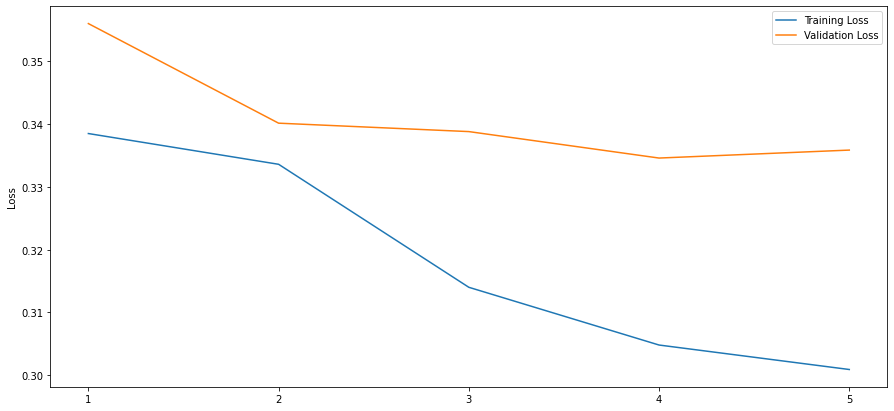

In [57]:
plt.figure(figsize=(15, 7))
RANGE = range(1, 6)
plt.plot(RANGE, train_loss,
         label = "Training Loss")
plt.plot(RANGE, val_loss, label = "Validation Loss")

plt.xticks(RANGE)
plt.ylabel('Loss')
plt.legend()
plt.savefig('NoisyLossPlot.png')
plt.show()

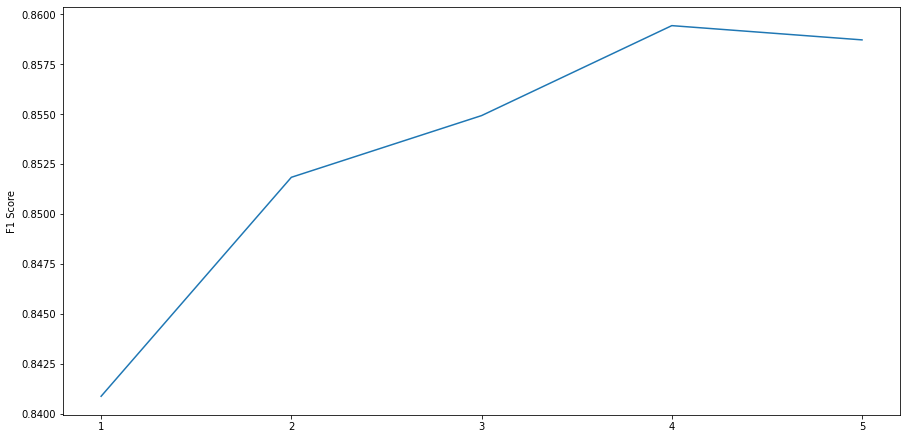

Max F1 Score at Epoch 4: 0.8594395326314473


In [60]:
#Plotting F1 Scores
plt.figure(figsize=(15, 7.5))
plt.plot(RANGE, val_F1)
plt.ylabel('F1 Score')
plt.xticks(RANGE)
plt.savefig('NoisyF1Plot.png')
plt.show()
max_value = max(val_F1)
max_index = val_F1.index(max_value) + 1
print(f"Max F1 Score at Epoch {max_index}: {max_value}")

# Epoch 4 performs the best so we will be using the model from epoch 4 

In [63]:
#step no 160500
predictions = trainer.predict(full_test_dataset)

The following columns in the test set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: Unnamed: 0, text. If Unnamed: 0, text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 14908
  Batch size = 32


In [64]:
print(predictions)

PredictionOutput(predictions=array([[ 1.2844193 , -1.2373391 ],
       [ 0.34289253, -0.35211933],
       [-2.9895635 ,  2.7084394 ],
       ...,
       [-1.735612  ,  1.6335813 ],
       [ 1.5382487 , -1.4909675 ],
       [ 0.46275756, -0.44103575]], dtype=float32), label_ids=array([1, 0, 1, ..., 1, 1, 0]), metrics={'test_loss': 0.42401960492134094, 'test_accuracy': 0.8127850818352562, 'test_recall': 0.8489385898407885, 'test_precision': 0.8821270310192023, 'test_f1': 0.865214661708601, 'test_runtime': 52.1867, 'test_samples_per_second': 285.667, 'test_steps_per_second': 8.929})


In [66]:
logits = predictions.predictions

In [67]:
predicted_val = np.argmax(logits, axis=-1)

In [69]:
true_vals = predictions.label_ids

In [71]:
cf_matrix = confusion_matrix(true_vals,predicted_val)
print("Confusion matrix is: \n")
print(cf_matrix)

Confusion matrix is: 

[[3159 1197]
 [1594 8958]]


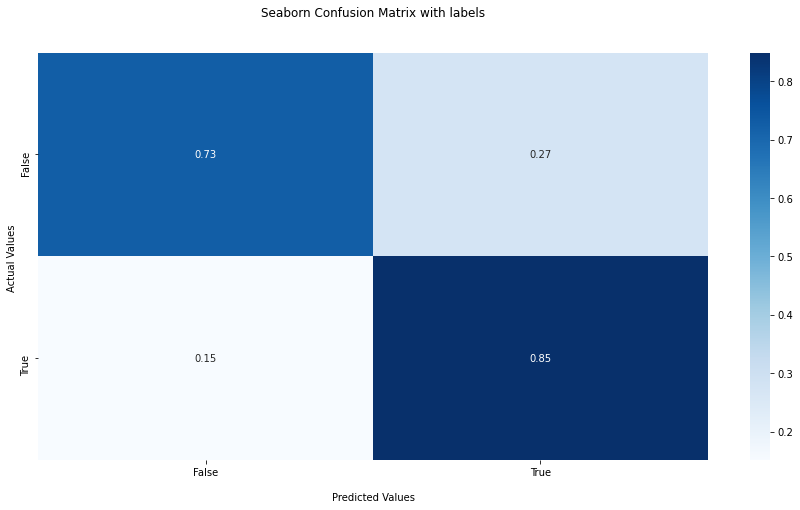

In [73]:
import seaborn as sns
plt.figure(figsize=(15, 7.5))

cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.savefig('NoisyConfusionPlot.png')
## Display the visualization of the Confusion Matrix.
plt.show()

# So the accuracy of the model is 0.8127850818352562 and F1 score is 0.865214661708601

In [79]:
print("Weighted F1 score is : \n ")
print(f1_score(true_vals,predicted_val,average='weighted'))

Weighted F1 score is : 
 
0.815070134333853


In [83]:
def accuracy_per_class(preds, labels):
    label_dict = {'Negative' : 0 , 'Positive' : 1}
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = preds.flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')
    
    print(f'Total accuracy is : {accuracy_score(labels_flat,preds_flat)}\n')
    
    return accuracy_score(labels_flat,preds_flat)

In [84]:
accuracy_per_class(predicted_val, true_vals)

Class: Negative
Accuracy:3159/4356

Class: Positive
Accuracy:8958/10552

Total accuracy is : 0.8127850818352562



0.8127850818352562